# PCFS Simulation
The code below generates second order correlation functions corresponding to a single Raman peak. The Raman peak can be modeled using a Gaussian or Lorentzian profile.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time as timing
import os
#from Edited_Photons_for_any_TTBIN import Photons
import random
import math
from numba import jit
from scipy.stats import poisson
import pandas as pd
import multiprocessing as mp

In [2]:
def coherence_length(wavelength_nm, delta_lambda_nm):
    # Convert wavelength from nm to meters
    wavelength_m = wavelength_nm * 1e-9
    
    # Convert delta_lambda from nm to meters
    delta_lambda_m = delta_lambda_nm * 1e-9
    
    # Calculate coherence length
    coherence_length_m = (wavelength_m ** 2) / (np.pi * delta_lambda_m)
    
    # Convert coherence length from meters to nm
    coherence_length_nm = coherence_length_m * 1e9
    
    return coherence_length_nm


def calculate_histograms(arrival_times):
    all_histograms = np.zeros((10,))  # Initialize an array to accumulate histograms
    for i, arrival_time in enumerate(arrival_times):
        time_differences = np.abs(arrival_times - arrival_time)  # Calculate time differences
        histogram, _ = np.histogram(time_differences, bins=10, range=(0, np.max(time_differences)))
        all_histograms += histogram  # Accumulate histograms
    return all_histograms

#this function assigns photons to channels the arrival time array has been created 
@jit(nopython=True)
def process_photon_arr(photon_arr, p1, random_number, buffer_size):
    photon_number = photon_arr.shape[0]
    for buffer in range(1, int(photon_number / buffer_size) + 1):
        upper_index = buffer * buffer_size
        lower_index = (buffer - 1) * buffer_size

        temp_arr = p1[lower_index:upper_index].reshape(-1, 1)

        mask = random_number[lower_index:upper_index] > temp_arr

        temp_photon_arr = photon_arr[lower_index:upper_index]
        mask = np.squeeze(mask)

        temp_photon_arr[mask, 0] = 2
        photon_arr[lower_index:upper_index] = temp_photon_arr

    return photon_arr

#this function will assign frequencies to photons given two specific frequencies
@jit
def assign_freq_for_binaryfreq(photon_number,sequence_length, ensamble_size, freq_array,top_freq, bot_freq):
    for j in range(0,photon_number,int(sequence_length)):
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        index0 = j
        index1 = int(j+sequence_length)
        
        prob = binomial_number/ ensamble_size
    
        for k in range(len(freq_array[index0:index1])):
            #change every other value to be 600 or 650c
            random_number = random.uniform(0,1)
         
            if random_number > prob:
                freq_array[index0+k] = bot_freq
            else:
                freq_array[index0+k] = top_freq


'''Old assignment function'''
def assign_gaussian_frequency_old(photon_number, sequence_length, ensamble_size, freq_array, top_freq ,bot_freq, std_dev):
    for j in range(0,photon_number,int(sequence_length)):
        index0 = j
        index1 = int(j+sequence_length)
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        prob = binomial_number/ ensamble_size
        
        
        random_number = random.uniform(0,1)
      
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=int(sequence_length))
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=int(sequence_length))
            
@jit
def assign_gaussian_frequency(photon_number, sequence_length, ensemble_size, freq_array, top_freq, bot_freq, std_dev):
    for j in range(0, photon_number - sequence_length + 1, sequence_length):
        index0 = j
        index1 = j + sequence_length
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=sequence_length)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=sequence_length)
    
    # Handle remaining photons
    remaining_photons = photon_number % sequence_length
    if remaining_photons > 0:
        index0 = photon_number - remaining_photons
        index1 = photon_number
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=remaining_photons)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=remaining_photons)


def assign_gaussian_frequency_v2(sequence_length, top_freq, bot_freq, std_dev, total_time, time_array, photon_number, expected_oscillations):
    time_freq_array = np.random.choice([top_freq, bot_freq], size=int(expected_oscillations))
    print(expected_oscillations)
    
    # Compute indices for frequency assignment
    indices = (time_array // (total_time * 1e12 / expected_oscillations)) % len(time_freq_array)
    
    # Use indices to assign frequencies with random noise
    freq_array = np.random.normal(time_freq_array[indices.astype(int)], std_dev)
    
    return freq_array


            
#############################################################################
@jit
def assign_gaussian_frequency_soft_switching(detector_resolution,probability_per_bin,sequence_length, total_time, time_array, photon_number, expected_oscillations,std_dev,top_freq,bot_freq):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.choice(np.array([top_freq, bot_freq]), size=int(expected_oscillations))
    print(switching_arr)
    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
    print(indices)
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency

    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
     
        center_frequency = switching_arr[1, index]
        # Draw from a Gaussian distribution with center frequency as mean
        #freq_arr[i] = np.random.normal(center_frequency, std_dev)
        #or lorenzian 
        freq_arr[i] = center_frequency + std_dev*np.random.standard_cauchy()
        #if you want to use two narrow lines
        #freq_arr[i] = center_frequency
    return freq_arr


@jit
def assign_gaussian_frequency_soft_switching_under_envelope(total_time, time_array, photon_number, expected_oscillations,std_dev,top_freq,std_dev2):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.normal(top_freq,std_dev2, size=int(expected_oscillations))
    print(switching_arr)
    indices = np.searchsorted(switching_arr[0, :], time_array, side='right')
    print(indices)
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
        center_frequency = switching_arr[1, index]
        # Draw from a Gaussian distribution with center frequency as mean
        #freq_arr[i] = np.random.normal(center_frequency, std_dev)
        #or lorenzian
        freq_arr[i] = center_frequency + std_dev*np.random.standard_cauchy()
        #if you want to use two narrow lines
        #freq_arr[i] = center_frequency
    return freq_arr

@jit
def parallelized_assign_gaussian_frequency_soft_switching_under_envelope(total_time, time_array, photon_number, expected_oscillations, std_dev, top_freq, std_dev2):
    # Generate sorted switching times and corresponding frequencies
    switching_times = np.sort(np.random.uniform(0, total_time * 1e12, size=expected_oscillations))
    switching_frequencies = np.random.normal(top_freq, std_dev2, size=expected_oscillations)
    
    # Use np.searchsorted in a vectorized manner to find the index for each time in time_array
    indices = np.searchsorted(switching_times, time_array, side='right') - 1

    # Generate the frequency array directly using vectorized operations
    # Generate random Gaussian noise around each center frequency
    freq_arr = switching_frequencies[indices] + std_dev * np.random.standard_cauchy(size=photon_number)
    
    return freq_arr
        
'''
these two functions have different perfomances but essentially do the same thing. It is better to use the first with large photon numner usually
and better to use the second with small photon number and or small bin size. I would test them to see what works best for your combination of detector 
resolution and photon number. the second usually works better If you arent at or near the array memory limit for time_arr
'''
@jit(nopython=True)
def simulate_arrival_time(time_arr, PPS, total_time, detector_resolution, probability_per_bin):
    for i in range(1, PPS * total_time):
        passed_bins = 1
        while time_arr[i] == 0:
            random_number = random.random()

            if probability_per_bin > random_number:
                time_arr[i] = time_arr[i - 1] + passed_bins * detector_resolution
            else:
                passed_bins += 1
                
@jit(nopython=True)
def simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins):
    for i in range(1, photon_number):
        arrival_bin = random.randint(0, int(number_of_bins))
     
        time_arr[i] = arrival_bin*detector_resolution
    time_arr_sorted = np.sort(time_arr)
    return time_arr_sorted


@jit(nopython=True)
def simulate_arrival_time_poisson(time_arr,PPS,total_time,detector_resolution):

    #draw inter-arrival times from exponential distribution
    inter_arrival_times = np.random.exponential(1/PPS,int(PPS*total_time))
    time_arr = np.cumsum(inter_arrival_times)

    #filter out arrival times that exceed the
    time_arr = time_arr[time_arr < total_time]

    #detector resolution in s
    detector_resolution = detector_resolution/1e12

    time_arr = np.round(time_arr/detector_resolution)*detector_resolution
    return time_arr

def arrival_time_vectorized(photon_number,total_time):
    time_arr = np.random.uniform(0, total_time*1e12, size=int(photon_number))
    return np.sort(time_arr)

def simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution):
    arrival_times = np.random.gamma(shape=1, scale=1/probability_per_bin, size=int(photon_number))
    arrival_times = np.cumsum(arrival_times) *detector_resolution
    return arrival_times


#writes stage positions in an exponential manner
def exp_spacing_position(number_of_pos, final_pos, stage_position):
    
    x = final_pos**(1/number_of_pos)
    
    for i in range(0,number_of_pos+1):
        new_pos = x**i
        stage_position.append(new_pos)
#writes stage positions in a linear manner
def linear_spacing_position(number_of_pos, final_pos, stage_position):
    x = final_pos/number_of_pos
    for i in range(number_of_pos):
        a = i
        new_pos = x*a
        stage_position.append(new_pos)
        

Parallelized Methods

In [3]:
def generate_and_sort_chunk(chunk_size, total_time):
    # Generate random photon arrival times for the chunk
    time_arr = np.random.uniform(0, total_time * 1e12, size=int(chunk_size))
    return np.sort(time_arr)

def parallel_arrival_time_vectorized(photon_number, total_time, num_processes=os.cpu_count()):
    # Determine chunk size
    chunk_size = photon_number // num_processes

    # Prepare arguments for each process
    args = [(chunk_size, total_time) for _ in range(num_processes)]

    # Parallel processing
    with mp.Pool(num_processes) as pool:
        sorted_chunks = pool.starmap(generate_and_sort_chunk, args)

    # Merge sorted chunks using heapq.merge, which performs an efficient merge of sorted iterables
    sorted_time_arr = np.array(list(heapq.merge(*sorted_chunks)))

    return sorted_time_arr

## Raman Waveshift Conversion

In [4]:

def convert_wn_to_wl(reighliegh_wavelength,raman_wavenumber,linewidth_cm, freq_jump_cm):
    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)
    #cm -1 to nm conversion 
    #for single conversion s

    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)

    #compute the nm shift for inverse cm shifts
    center_peak1 = raman_wavenumber
    upper_end1 = center_peak1+linewidth_cm/2
    lower_end1 = center_peak1-linewidth_cm/2
    upper_nm1 = 1e7/(1e7/reighliegh_wavelength-upper_end1)
    lower_nm1= 1e7/(1e7/reighliegh_wavelength-lower_end1)

    #linewidth in nm 
    linewidth_nm = (upper_nm1-lower_nm1)/2

    #compute the nm shift for inverse cm shifts
 
    center_peak = raman_wavenumber
    upper_end = center_peak+freq_jump_cm
    lower_end = center_peak
    upper_nm = 1e7/(1e7/reighliegh_wavelength-upper_end)
    lower_nm = 1e7/(1e7/reighliegh_wavelength-lower_end)

    #linewidth in nm 
    nm_shift = upper_nm-lower_nm

    return (raman_wavelength, nm_shift, linewidth_nm)

def convert_wn_to_wl_v2(reighliegh_wavelength,raman_wavenumber,linewidth_cm_1, linewidth_cm_2,freq_jump_cm):
    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)
    #cm -1 to nm conversion 
    #for single conversion s

    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)

    #compute the nm shift for inverse cm shifts
    center_peak1 = raman_wavenumber
    upper_end1 = center_peak1+linewidth_cm_1/2
    lower_end1 = center_peak1-linewidth_cm_1/2
    upper_nm1 = 1e7/(1e7/reighliegh_wavelength-upper_end1)
    lower_nm1= 1e7/(1e7/reighliegh_wavelength-lower_end1)

    #linewidth in nm 
    linewidth_nm_1 = (upper_nm1-lower_nm1)/2

    #compute the nm shift for inverse cm shifts
 
    center_peak = raman_wavenumber
    upper_end = center_peak+freq_jump_cm
    lower_end = center_peak
    upper_nm = 1e7/(1e7/reighliegh_wavelength-upper_end)
    lower_nm = 1e7/(1e7/reighliegh_wavelength-lower_end)

    #linewidth in nm 
    nm_shift = upper_nm-lower_nm

    #linewidth in nm 
    linewidth_nm_1 = (upper_nm1-lower_nm1)/2

    #compute nm shift for Lorentzian
    upper_end2 = center_peak1+linewidth_cm_2/2
    lower_end2 = center_peak1-linewidth_cm_2/2
    upper_nm2 = 1e7/(1e7/reighliegh_wavelength-upper_end2)
    lower_nm2= 1e7/(1e7/reighliegh_wavelength-lower_end2)

    linewidth_nm_2 = (upper_nm2-lower_nm2)/2

    return (raman_wavelength, nm_shift, linewidth_nm_1, linewidth_nm_2)


#print(convert_wn_to_wl(633,810,1.5, 2))

Writes g2 data into file and plots if parameter is set to True

In [5]:
def get_g2_data(photon1, file_name, counter, pos, cmap, directory, ensamble_size= 1, plot=False):
    
    photon1.write_total_data_to_file(sync_channel = 1)  
    bin_size = 1e9
    photon1.get_intensity_trace(directory, file_name, bin_size)
        
    photon1.photon_corr(directory, file_name, 'cross-correlation', [1,2], (1e1,1e12), 3)

    '''
    if counter ==0 or counter == 5 or counter ==49:
            
            #graphing
            channel1 = [row[1] for row in photon1.intensity_counts['trace'] ]
            time1 = np.linspace(0, len(channel1), len(channel1))

            channel2 = [row[2] for row in photon1.intensity_counts['trace'] ]
            time2 = np.linspace(0, len(channel2), len(channel2))

            # Calculate min and max values for each channel
            min_values = [np.min(channel1), np.min(channel2)]
            max_values = [np.max(channel1), np.max(channel2)]
            
            # Calculate ratio of min:max for each channel
            ratios = [min_val / max_val for min_val, max_val in zip(min_values, max_values)]
            if counter ==0:
                c = .1
            if counter == 5:
                c = .5
            if counter == 49:
                c = .7
    '''
    #graph g2
    if plot==True:  
        plt.figure(figsize = (10,6), dpi = 300)
        if counter == 0 or counter == 1 or counter == 4 or counter == 8 or counter == 20:
                x_value = 1e6
                idx = np.argmin(np.abs(photon1.cross_corr['lags'] - x_value))
                x_value = photon1.cross_corr['lags'][idx]
                y_value = photon1.cross_corr['corr_norm'][idx]

                
                plt.plot(photon1.cross_corr['lags'], photon1.cross_corr['corr_norm'], color=cmap(counter/30+.3), linewidth=2, label  = fr'$\delta$ = {i//1e3}(mm)')  # Adjust line color and thickness
                    
                plt.ylim(0, 2)
                plt.title(f"g^2(tau)  at pos {int(pos)}nm and ensamble size {ensamble_size} " , fontsize=16)  # Increase font size of title
                plt.xlabel('Time (ps)', fontsize=14)  # Increase font size of x-axis label
                plt.ylabel('A.U.', fontsize=14)  # Increase font size of y-axis label
                plt.xscale('log')

                plt.tick_params(axis='both', which='major', labelsize=12)  # Increase font size of tick labels

    g2_data = pd.DataFrame({"time (ps)" : photon1.cross_corr['lags'], "a.u." : photon1.cross_corr['corr_norm']})
    g2_filename = f"g2_pos{int(pos)}.csv"
    g2_path = os.path.join(directory, g2_filename)
    g2_data.to_csv(g2_path, index=False)
         

Run Simulations with Raman Peak Parameters

In [8]:
import import_ipynb
import photons
#what directory and filename to store the .photons file
 
#directory ='/global/scratch/projects/co_utzatgroup/ccobbbruno/24_05_08_test_to_run_files/'
#directory = "C:\\Users\\Aditi\\OneDrive\\UtzatGroup\\07_10_24_test_sim_1e5_g2\\"


def run_simulation(directory, num_stage_pos, photons_per_emitter, raman_wavenumber, line_width_cm, gaussian_std_dev, freq_jump_cm, display_plot = False):

    #total_start = timing.time()
    #correlation_arr = []
    #print("Directory" + directory)

    #open the file for the position documentation
    pos_file_name = directory + os.sep +'posFile.pos'
    pcfs_file_name = directory + os.sep +'position.pcfslog'
    pos_file = open(pos_file_name,'w')
    pcfs_log_file = open(pcfs_file_name, 'w')

    '''
    ===============================================================================================================
    ===============================================================================================================
    '''
    #here std_dev is a parameter related to the linewidth of the lorenzian, it is half of the FWHM value
    top_freq , dif, half_linewidth = convert_wn_to_wl(reighliegh_wavelength = 633,raman_wavenumber = raman_wavenumber,linewidth_cm = line_width_cm, freq_jump_cm = freq_jump_cm)

    #top_freq = 709
    bot_freq = top_freq+ dif
    print(top_freq, bot_freq, half_linewidth)

    ensamble_size = 1
    #photons per emitter per second
    photons_per_emitter =photons_per_emitter
    # Define time of simulation in s
    total_time =int(1)

    # Define number of photons per second
    PPS = int(ensamble_size*photons_per_emitter)


    # Define detector resolution in ps
    #detector_resolution = 1e2
    #the number of cycles you expect the frequency to go through in ps
    switching_time = 1e8
    expected_oscillations = int(total_time*1e12/switching_time)
    '''
    ===============================================================================================================
    ===============================================================================================================
    '''
    # Calculate coherence length
    coherence_length_result = coherence_length(bot_freq, half_linewidth)
    print("Coherence Length:", coherence_length_result, "nm") 

    #choose center stage positions in nm as path length differences 
    stage_position = []
    number_of_pos = num_stage_pos
    final_pos = coherence_length_result #in nm. 1e8 is the largest possible stage pos but dont increase sim beyond 7e5 in practicality
    linear_spacing_position(number_of_pos, final_pos,stage_position)
    cmap = plt.get_cmap('inferno')
    plt.figure(figsize = (10,6), dpi = 200)
    counter = 0
    corr_list = []

    for i in stage_position:

        photon_number =int(np.random.poisson(int(PPS*total_time)))
        
        projected_time_start = timing.time()
        
        file_name = f'pos{int(i)}'
        
        '''
        there is a problem with sequence length that it must be at least one. I need to find a work around so that I look at arival time to see what freq a photon should be'''
        #create an array that switches between two values 
        sequence_length = photon_number/expected_oscillations  # Length of each sequence 
        
        # Calculate probability of finding a photon in a detector bin
        #probability_per_bin = (PPS / 1e12) * detector_resolution
        #number_of_bins = total_time*1e12/detector_resolution
        
        time_arr = np.zeros(photon_number, dtype = np.float32)
        #simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins)
        start1 = timing.time()
        #assign time of arrival
        time_arr  = arrival_time_vectorized(photon_number,total_time)
        #time_arr = parallel_arrival_time_vectorized(photon_number, total_time)
        
        #print(len(time_arr))
        end1 = timing.time()
        
        print(f'time to simulate arrival times {end1-start1}')
        print(f'Oscillation period is {sequence_length*(1/PPS)*(1e12)} ps')
        
        freq_array = np.zeros(photon_number, dtype = np.float32)
    
        start4 = timing.time()

        #freq_array = assign_gaussian_frequency_v2(sequence_length,total_time,time_arr,photon_number,expected_oscillations)
        #freq_array = assign_gaussian_frequency_soft_switching(detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations,std_dev,top_freq,bot_freq)
        
        freq_array = assign_gaussian_frequency_soft_switching_under_envelope(total_time, time_arr, photon_number, expected_oscillations,half_linewidth,top_freq,gaussian_std_dev)
        #freq_array = parallelized_assign_gaussian_frequency_soft_switching_under_envelope(total_time, time_arr, photon_number, expected_oscillations,half_linewidth,top_freq,gaussian_std_dev)
        end4 = timing.time()
        print(f'time to assign freq {end4-start4}')
    
        #center stage pos in nm as a path length difference
        center_stage_position = i
        #amplitude in nm /2 this is from center to peak 
        dither_amplitude = 1200
        #period in  picoseconds
        dither_time_period =int(1e12)
        time_between_stage_steps = 1e6
        measurement_mode = 2
        
        start1 = timing.time()
        #all data for each photon stored in an array, first column is channel, second is arrival time, fourth is frequency, third is a place holder if the sim will expand to add relative time to a pulse
        photon_arr = np.zeros((photon_number, 4), dtype= np.float32)

        #set the 4th column to be photon color
        photon_arr[:,3]= freq_array
        #set the first column to be channel 1
        photon_arr[:,0] =1
        
        photon_arr[:,1] = time_arr

        
        #create dither waveform 
        #make sure the dither period is divisible by 4 to work with nice round numbers
        
        dither_waveform = np.zeros(int(dither_time_period/time_between_stage_steps),dtype=np.float32)
    
        dither_waveform[:int(dither_time_period/(4*time_between_stage_steps))] = np.linspace(center_stage_position , dither_amplitude+center_stage_position,int(dither_time_period/(4*time_between_stage_steps)))
        dither_waveform[int(dither_time_period/(4*time_between_stage_steps)):int(3*dither_time_period/(4*time_between_stage_steps))] = np.linspace(dither_amplitude+center_stage_position , center_stage_position-dither_amplitude, int(dither_time_period/(2*time_between_stage_steps)))
        dither_waveform[int(3*dither_time_period/(4*time_between_stage_steps)):] = np.linspace(center_stage_position-dither_amplitude , center_stage_position,  int(dither_time_period/(4*time_between_stage_steps)))
        
        #Find where we are in the dither given absolute time
        relative_dither_time = photon_arr[:,1] % dither_time_period
        
        stage_pos = np.zeros(photon_number, dtype= np.float32)

        '''
        =====================
        may need to keep the loop if you would like to work with photon numbers larger thatn 1e8 to avoid memory problems
        =====================
        #find the stage position given the photons time in relation to stage position
        '''

        for k in range(photon_number):
            index = int(relative_dither_time[k]/time_between_stage_steps)
        
            stage_pos[k] = dither_waveform[index]
        
        '''
        # Convert relative_dither_time to indices directly
        indices = (relative_dither_time / time_between_stage_steps).astype(int)

        # Use array indexing to assign values to stage_pos
        stage_pos = dither_waveform[indices]
        '''

        #based on interference contstruct a probability of going to one detector or the other, this also serves to make the detectors anticorrelated in phase
        p1 = .5 +.5*np.cos(4*np.pi*stage_pos[:]/photon_arr[:,3])
        
        '''
        =====================================
        again, may need to keep loop if the arrays get too memory intensive
        =====================================
        '''
        random_number  = np.random.rand(photon_number, 1)

        start2 = timing.time()
        
        '''
        buffer_size = 1e5
        #assigns channels give probability, likely could be recast as a function above and forgo the buffering
        for buffer in range(1, int(photon_number/buffer_size)+1):
            upper_index = buffer*buffer_size
            lower_index = (buffer-1)*buffer_size
            
            temp_arr = p1[lower_index:upper_index].reshape(-1, 1)
            
            mask = random_number[lower_index:upper_index]>temp_arr
            
            temp_photon_arr = photon_arr[lower_index:upper_index]
            mask = np.squeeze(mask)
            
            temp_photon_arr[mask,0] = 2
            photon_arr[lower_index:upper_index] = temp_photon_arr
        end2 = timing.time()
        print(f'time to make photons array {end2-start2}')
        
        '''
        random_number = np.random.rand(photon_number, 1)

        start2 = timing.time()

        # Reshape p1 array to match the shape of random_number
        p1_reshaped = p1.reshape(-1, 1)

        # Use vectorized comparison to create mask
        mask = random_number > p1_reshaped

        # Convert mask to boolean array
        mask = np.squeeze(mask)

        # Modify photon_arr in-place using boolean indexing
        photon_arr[mask, 0] = 2

        end2 = timing.time()
        print(f'time to make photons array {end2 - start2}')
        
        #write positions to file as nm
        value = str(i*1e-6)
        
        pos_file.write(value + "\n")
        pcfs_log_file.write(value + "\n")
        
        #write data to .photons file
        if measurement_mode == 2:
            photons_mimic = photon_arr[:,:2]
            photons_mimic = photons_mimic.flatten()
            
            #write photons file in binary
            fout_path = os.path.join(directory, f"{file_name}.photons")
            with open(fout_path, 'wb') as fout:            
                photons_mimic.astype(np.uint64).tofile(fout)
            fout.close()

        #initialize instance of Photon class to record g2 data
        photon1 = photons.Photons(directory, 2, simulation = True, file_name = file_name, memory_limit = 2)
        
        #plot and store g2 data into two arrays
        get_g2_data(photon1, file_name, counter, i, cmap, directory, display_plot)
        #os.remove(fout)
            
        #corr_list.append(photon1.cross_corr['corr_norm'])
        print(f'stage position {counter} completed')
        projected_time_end = timing.time()
        total_for_one_loop = projected_time_end - projected_time_start
        total_time_proj = total_for_one_loop * number_of_pos
        time_left = total_time_proj - total_for_one_loop*counter
        print(f'total time to complete is {int(total_time_proj/60)}mins and the total time left is {int(time_left/60)}mins')
        plt.show()
        counter += 1

    pos_file.close() 
    pcfs_log_file.close()


In [1]:
import multiprocessing as mp
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Other imports for functions like convert_wn_to_wl, coherence_length, etc.

def process_stage_position(i, directory, PPS, total_time, num_stage_pos, raman_wavenumber, line_width_cm, gaussian_std_dev, freq_jump_cm, top_freq, bot_freq, half_linewidth, display_plot):
    photon_number = int(np.random.poisson(int(PPS * total_time)))

    file_name = f'pos{int(i)}'
    
    time_arr = arrival_time_vectorized(photon_number, total_time)

    freq_array = assign_gaussian_frequency_soft_switching_under_envelope(total_time, time_arr, photon_number, expected_oscillations, half_linewidth, top_freq, gaussian_std_dev)
    
    center_stage_position = i
    dither_amplitude = 1200
    dither_time_period = int(1e12)
    time_between_stage_steps = 1e6

    dither_waveform = np.zeros(int(dither_time_period / time_between_stage_steps))
    dither_waveform[:int(dither_time_period / (4 * time_between_stage_steps))] = np.linspace(center_stage_position, dither_amplitude + center_stage_position, int(dither_time_period / (4 * time_between_stage_steps)))
    dither_waveform[int(dither_time_period / (4 * time_between_stage_steps)):int(3 * dither_time_period / (4 * time_between_stage_steps))] = np.linspace(dither_amplitude + center_stage_position, center_stage_position - dither_amplitude, int(dither_time_period / (2 * time_between_stage_steps)))
    dither_waveform[int(3 * dither_time_period / (4 * time_between_stage_steps)):] = np.linspace(center_stage_position - dither_amplitude, center_stage_position, int(dither_time_period / (4 * time_between_stage_steps)))
    
    relative_dither_time = time_arr % dither_time_period
    indices = (relative_dither_time / time_between_stage_steps).astype(int)
    stage_pos = dither_waveform[indices]

    p1 = 0.5 + 0.5 * np.cos(4 * np.pi * stage_pos / photon_arr[:, 3])
    random_number = np.random.rand(photon_number, 1)
    mask = np.squeeze(random_number > p1.reshape(-1, 1))
    photon_arr = np.zeros((photon_number, 4))
    photon_arr[:, 3] = freq_array
    photon_arr[:, 0] = 1
    photon_arr[:, 1] = time_arr
    photon_arr[mask, 0] = 2

    # Write data to files and perform further calculations
    pos_file_name = directory + os.sep + 'posFile.pos'
    pcfs_file_name = directory + os.sep + 'position.pcfslog'
    with open(pos_file_name, 'a') as pos_file, open(pcfs_file_name, 'a') as pcfs_log_file:
        pos_file.write(f"{i * 1e-6}\n")
        pcfs_log_file.write(f"{i * 1e-6}\n")

    fout_path = os.path.join(directory, f"{file_name}.photons")
    photons_mimic = photon_arr[:, :2].flatten()
    with open(fout_path, 'wb') as fout:
        photons_mimic.astype(np.uint64).tofile(fout)

    # Perform g2 analysis (assuming this function is independent)
    photon1 = photons.Photons(directory, 2, simulation=True, file_name=file_name, memory_limit=1)
    get_g2_data(photon1, file_name, i, i, cmap, directory, display_plot)

    return photon1.cross_corr['corr_norm']

def run_simulation_parallel(directory, num_stage_pos, photons_per_emitter, raman_wavenumber, line_width_cm, gaussian_std_dev, freq_jump_cm, display_plot=False):
    top_freq, dif, half_linewidth = convert_wn_to_wl(reighliegh_wavelength=633, raman_wavenumber=raman_wavenumber, linewidth_cm=line_width_cm, freq_jump_cm=freq_jump_cm)
    bot_freq = top_freq + dif

    ensamble_size = 1
    PPS = int(ensamble_size * photons_per_emitter)
    total_time = int(1)

    coherence_length_result = coherence_length(bot_freq, half_linewidth)
    stage_position = []
    final_pos = coherence_length_result
    linear_spacing_position(num_stage_pos, final_pos, stage_position)

    # Multiprocessing Pool
    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Use partial to fix the common parameters
        func = partial(process_stage_position, directory=directory, PPS=PPS, total_time=total_time, num_stage_pos=num_stage_pos, raman_wavenumber=raman_wavenumber, line_width_cm=line_width_cm, gaussian_std_dev=gaussian_std_dev, freq_jump_cm=freq_jump_cm, top_freq=top_freq, bot_freq=bot_freq, half_linewidth=half_linewidth, display_plot=display_plot)
        
        # Map stage positions to processes
        corr_list = pool.map(func, stage_position)
        print("")

    print("Simulation completed.")
    return corr_list

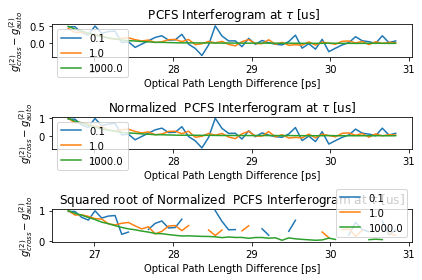

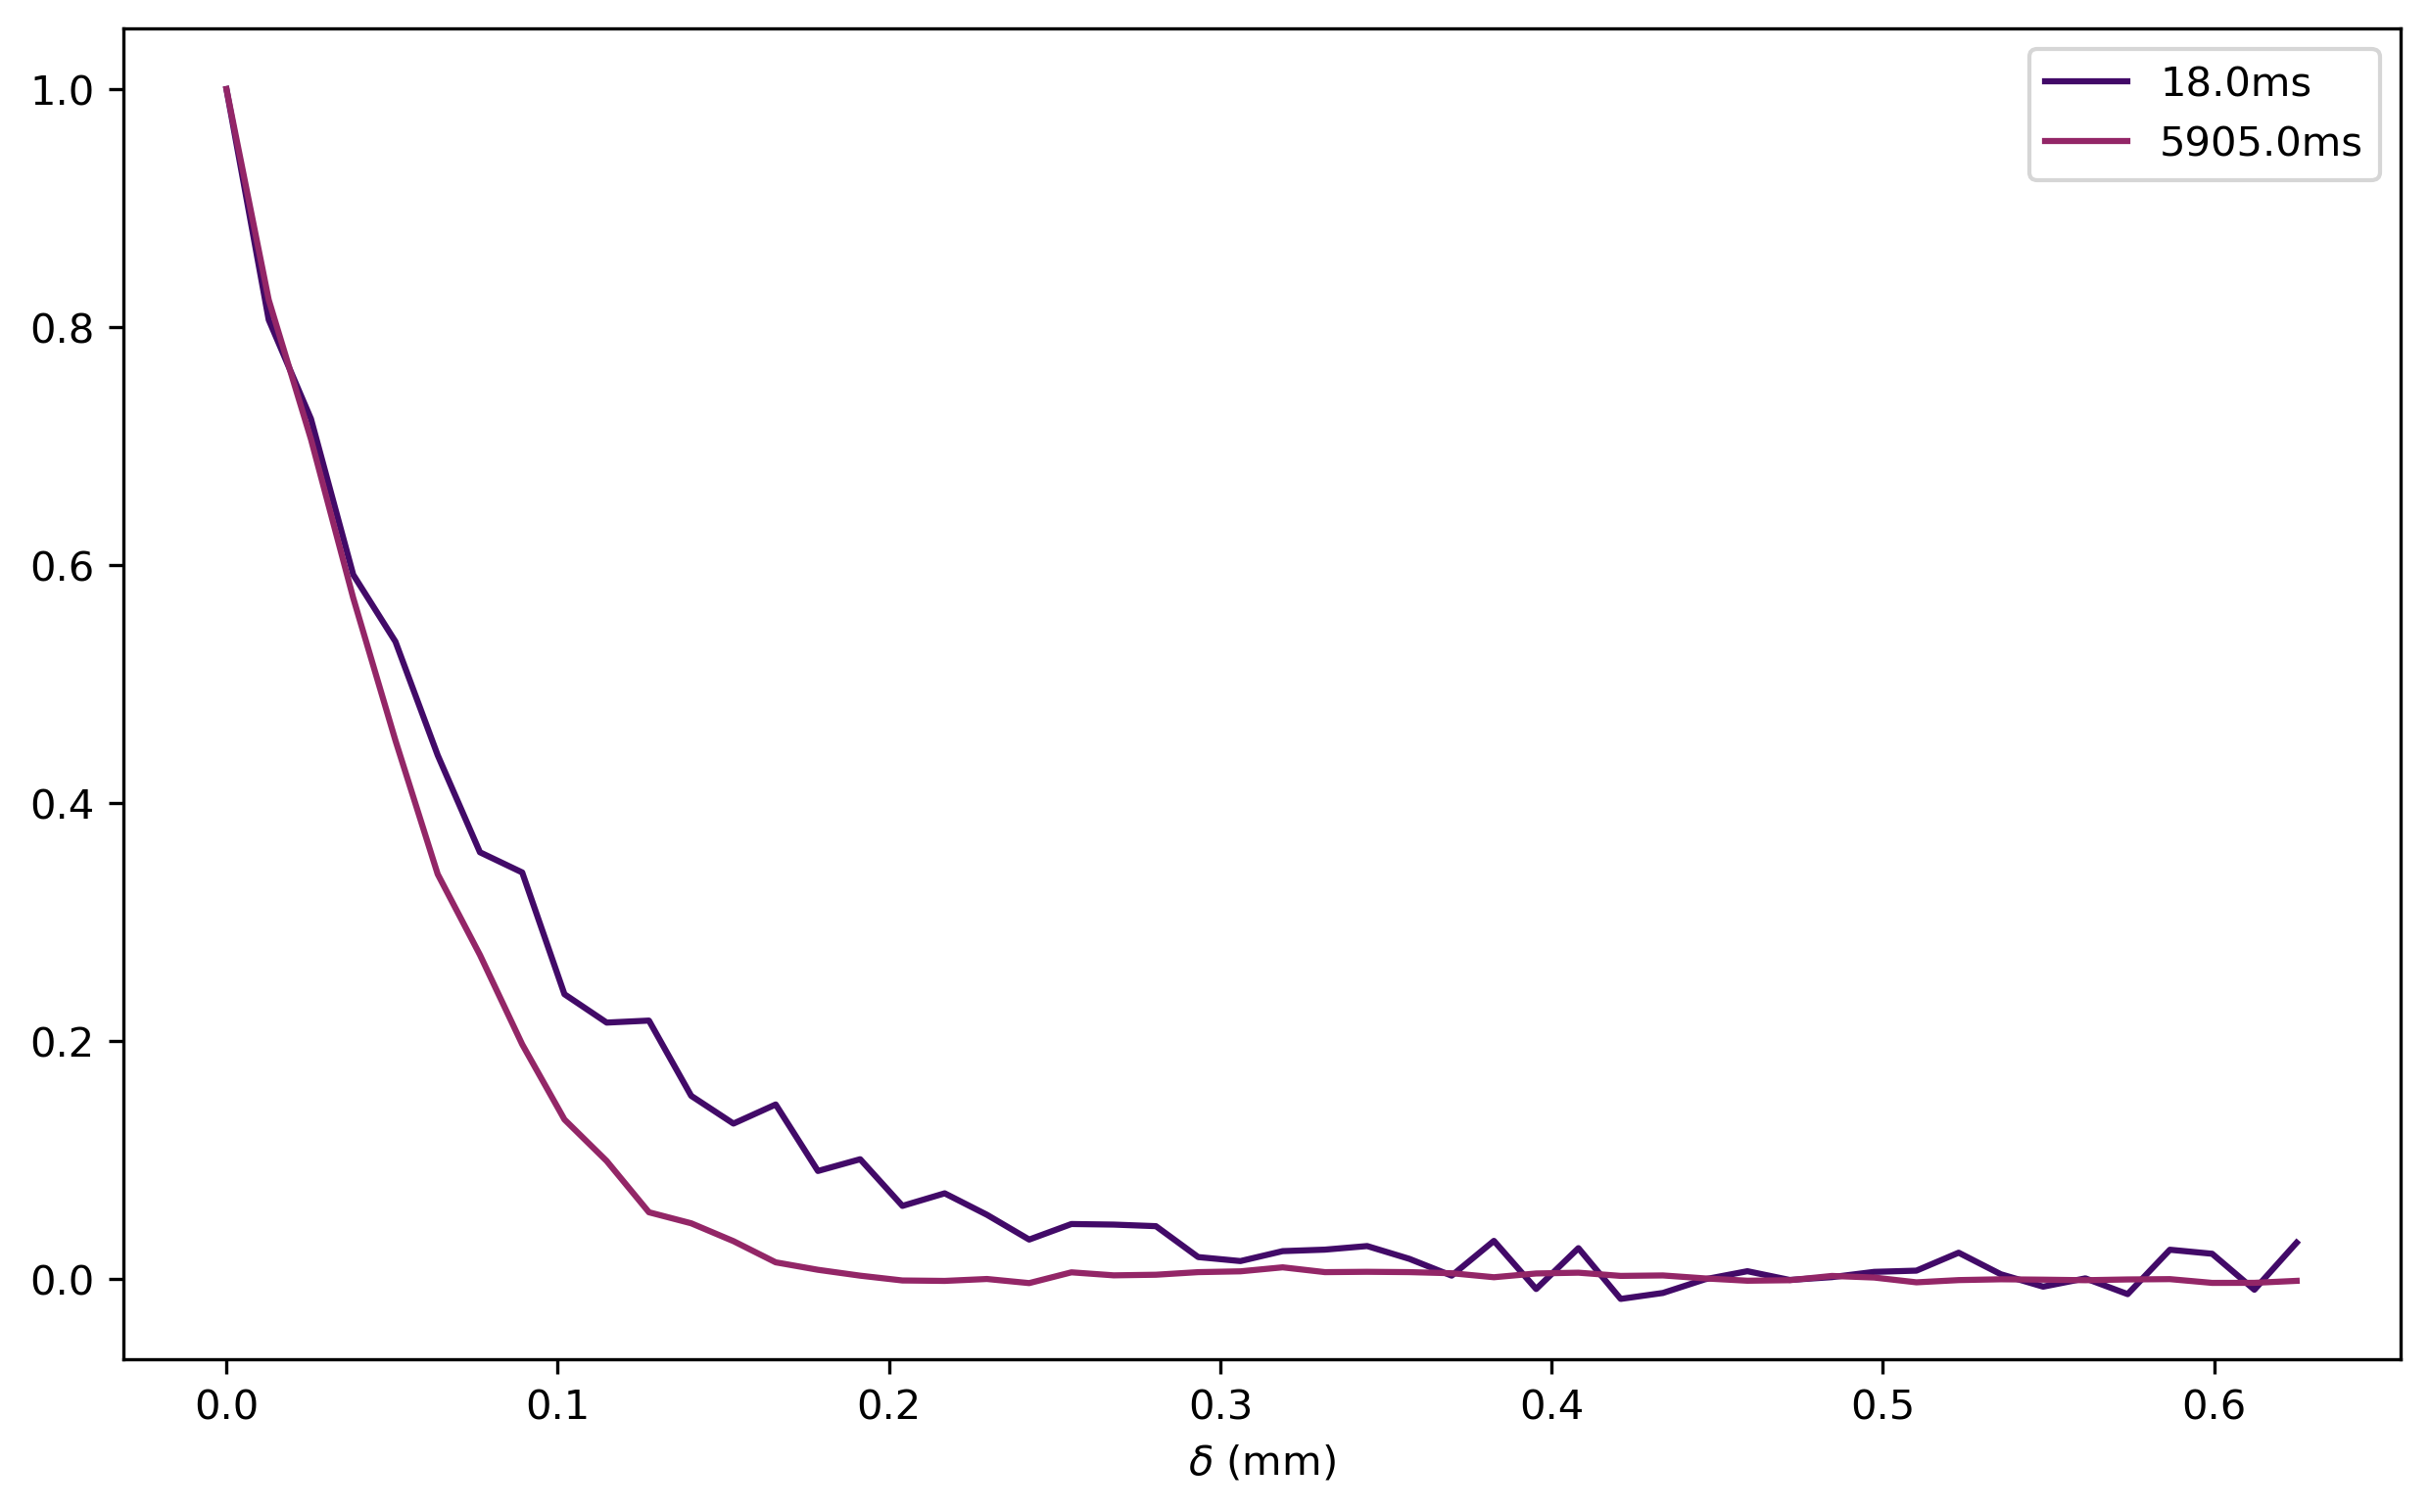

In [ ]:
#%%
'''
pcfs1.get_blinking_corrected_PCFS()

pcfs1.plot_spectral_diffusion([1e5,1e6,1e9], -4)
pcfs1.get_mirror_spectral_corr(0, 0)
pcfs1.get_splev_mirror_spec_corr( 0, 0)

cmap = plt.get_cmap('inferno')
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(pcfs1.stage_positions,pcfs1.blinking_corrected_PCFS_interferogram[60, :]/max(pcfs1.blinking_corrected_PCFS_interferogram[60, :]),color = cmap(.2), label = (f'{pcfs1.tau[60]//1e6}ms'))
plt.plot(pcfs1.stage_positions,pcfs1.blinking_corrected_PCFS_interferogram[85, :]/max(pcfs1.blinking_corrected_PCFS_interferogram[85, :]),color = cmap(.4),label = (f'{pcfs1.tau[85]//1e6}ms'))
plt.xlabel(f'$\delta$ (mm)')
plt.legend()
plt.savefig(directory + 'interferogram.svg')
plt.show()
'''

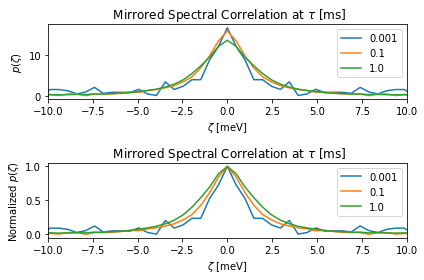

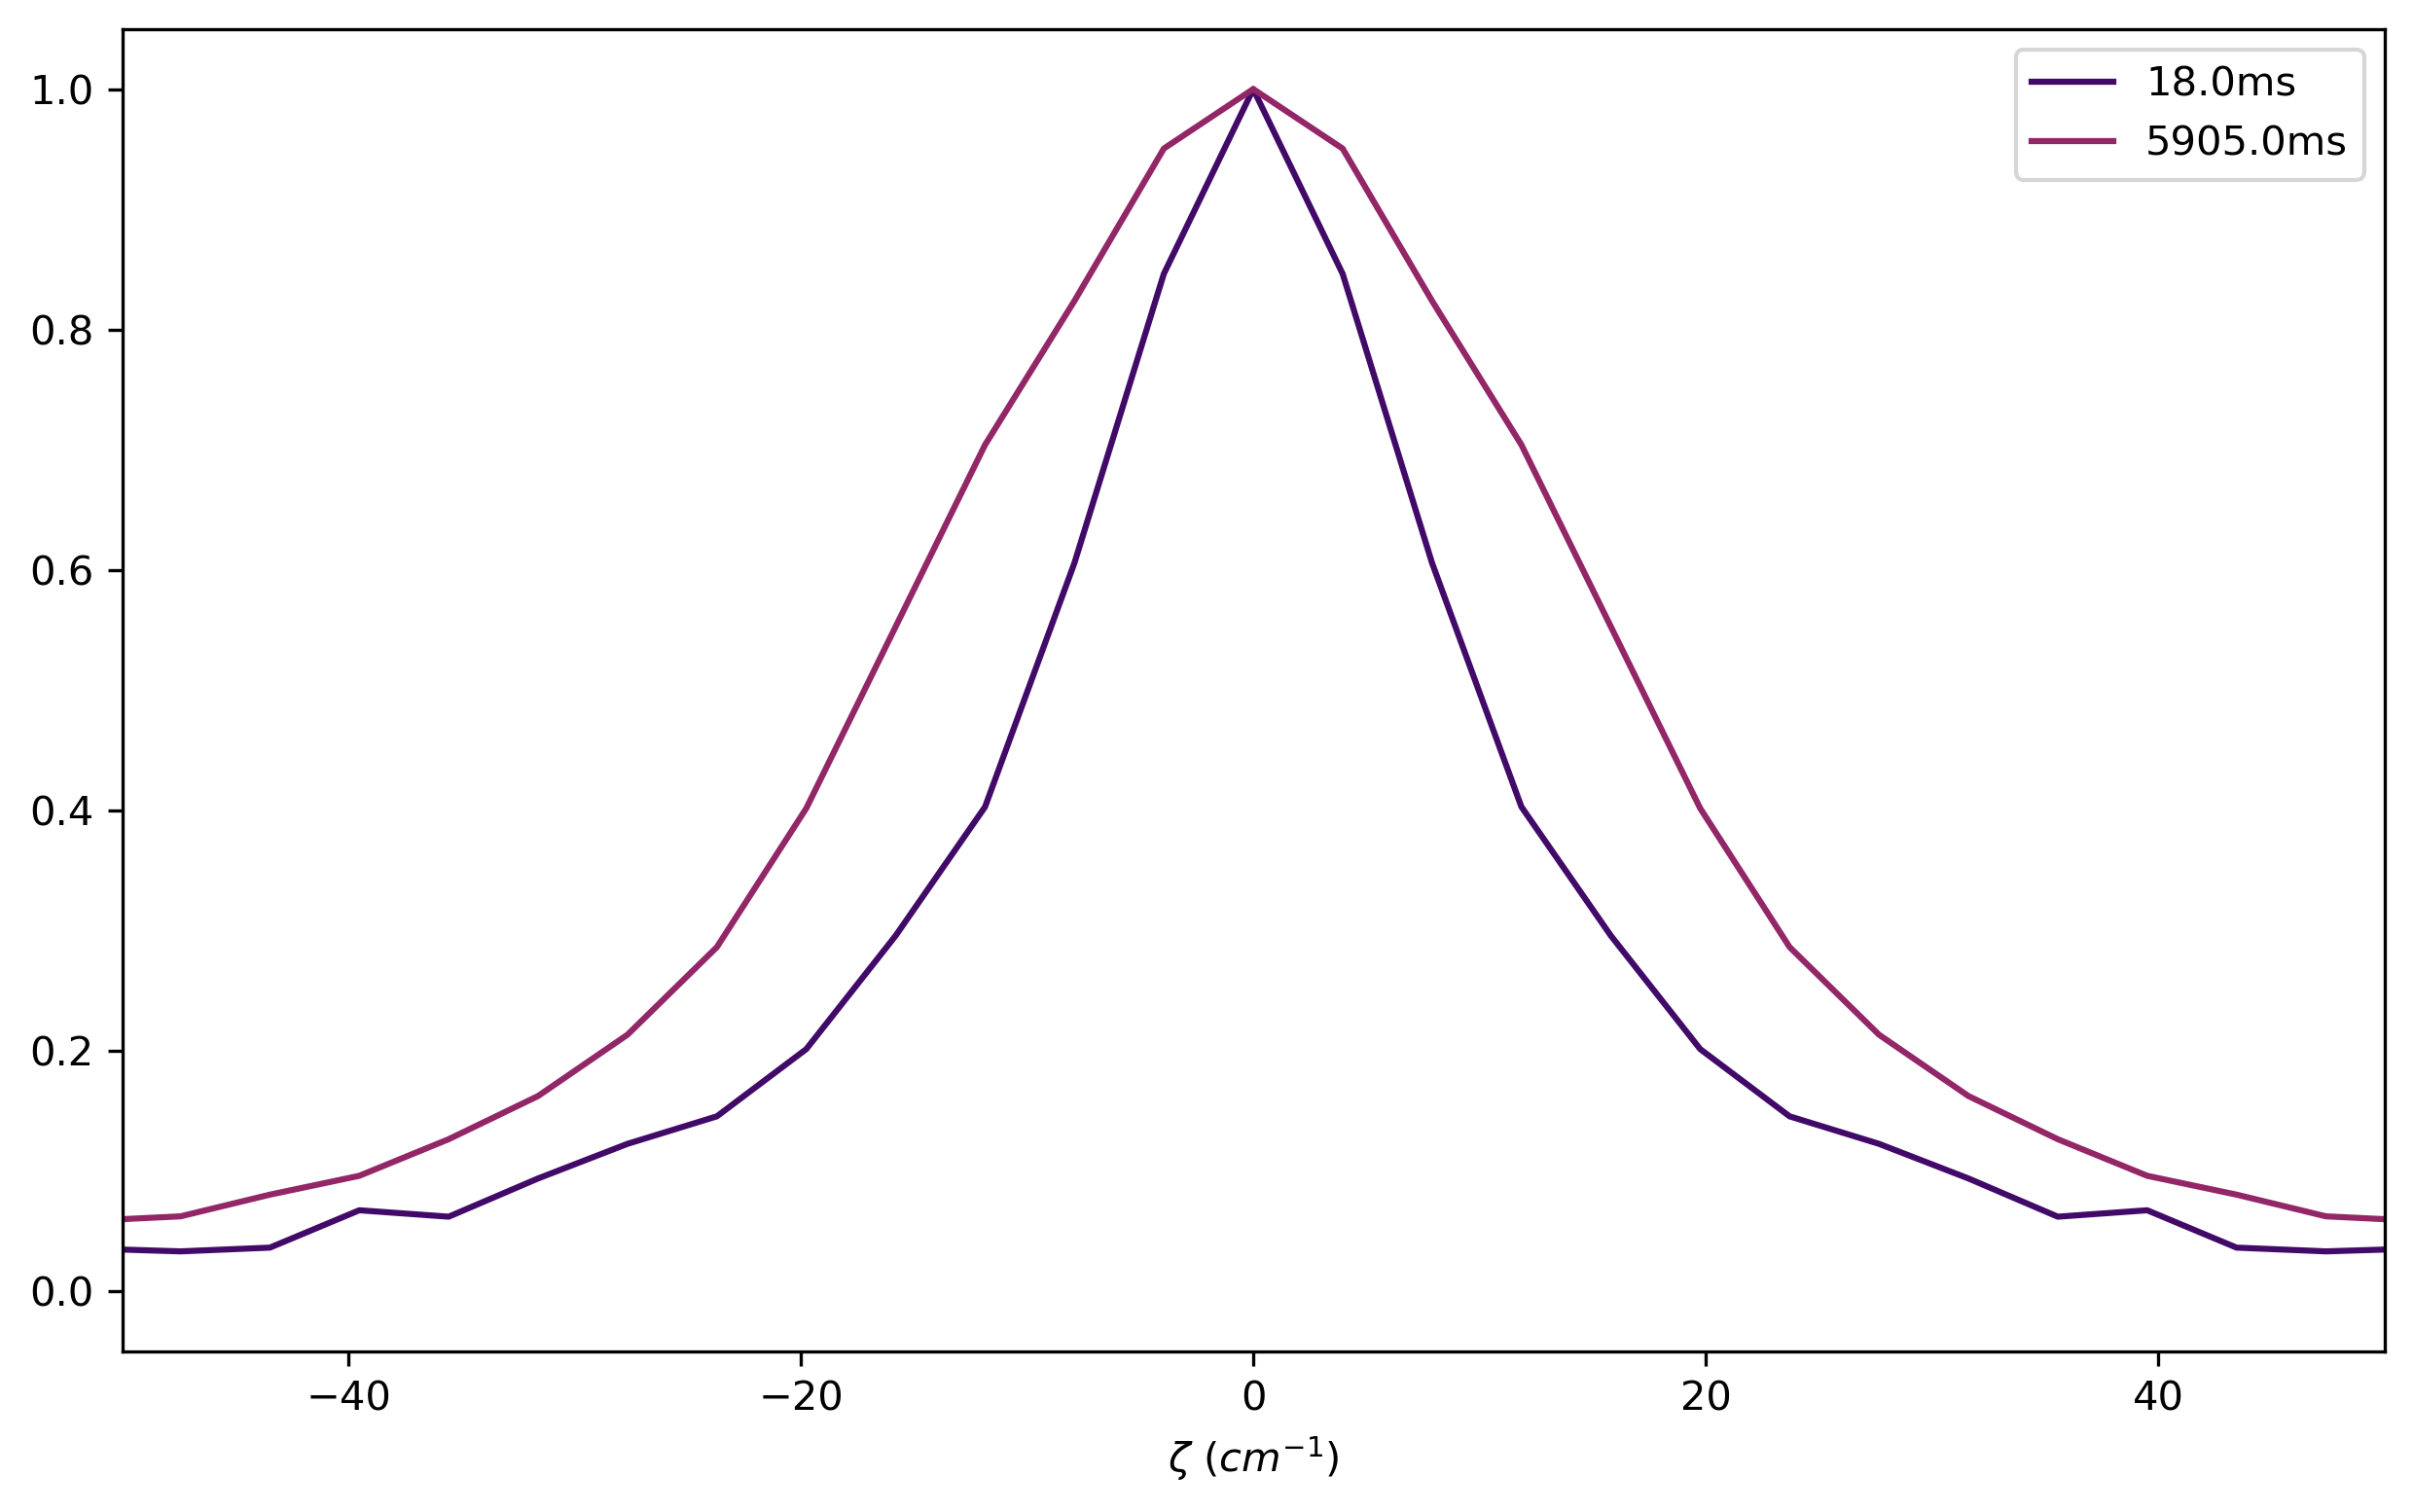

In [ ]:
'''
pcfs1.plot_splev_spec_corr([1e6,1e8,1e9],(-10,10))

cmap = plt.get_cmap('inferno')
plt.figure(figsize = (10,6), dpi = 300)
plt.plot(pcfs1.splev_spec_corr['zeta']*8,pcfs1.splev_spec_corr['spectral_corr'][60,:]/max(pcfs1.splev_spec_corr['spectral_corr'][60,:]),color = cmap(.2), label = (f'{pcfs1.tau[60]//1e6}ms'))
plt.plot(pcfs1.splev_spec_corr['zeta']*8,pcfs1.splev_spec_corr['spectral_corr'][84,:]/max(pcfs1.splev_spec_corr['spectral_corr'][84,:]),color = cmap(.4),label = (f'{pcfs1.tau[85]//1e6}ms'))
plt.xlabel(r'$\zeta$ ($cm^{-1}$)')
plt.legend()
plt.xlim(-50,50)
plt.savefig(directory + 'spec_diffusion.svg')
plt.show()
'''

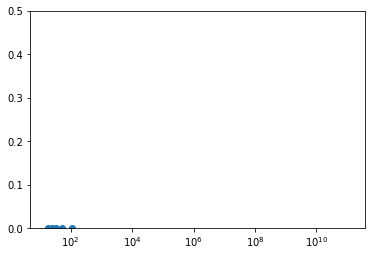

total run time: 131.51702523231506


In [ ]:
'''
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def lorenzian(x, x0, gamma, A):
    return A * (gamma / ((x - x0) ** 2 + gamma ** 2) / np.pi)

fwhm_arr = []
for i in range(len(pcfs1.tau)):
    y = pcfs1.splev_spec_corr['spectral_corr'][i,:]/max(pcfs1.splev_spec_corr['spectral_corr'][i,:])
    x = pcfs1.splev_spec_corr['zeta']
    try:
        params, covariance = curve_fit(lorenzian, x, y)
    except RuntimeError:
        fwhm_arr.append(0)
    else:
        #for lorenzian
        fwhm = 2 * params[1] 
        #for gaussian
        #fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
        fwhm_arr.append(fwhm)
        #plt.plot(x, y, 'bo', label='Data')
        #plt.plot(x, lorenzian(x, *params), 'r-', label='Fit')
        #plt.legend()
        
        #plt.show()

#%%
plt.scatter(pcfs1.tau,fwhm_arr, label='Scatter Plot on Log Scales')
plt.xscale('log')
#plt.xlim(1e4,1e11)
plt.ylim(0,.5)
plt.show()
total_end = timing.time()
print(f'total run time: {total_end-total_start}')
'''

# Lorentzian Convolution


In [9]:
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Lorentzian functions f(x) and g(x)
def lorentzian(x, A, x0, gamma):
    return A * (gamma / np.pi) / ((x - x0)**2 + gamma**2)

# Parameters for the Lorentzian functions f(x) and g(x)
std_dev = 10
dif = 10

A_f = 1
x0_f = 0
gamma_f = std_dev

A_g = 1
x0_g = dif
gamma_g = std_dev

print(std_dev,dif)

# Define the range and step size for x
x_min = -1
x_max = 1
delta_x = .01
x_values = np.arange(x_min, x_max, delta_x)

# Compute the values of f(x) and g(x)
f_x = lorentzian(x_values, A_f, x0_f, gamma_f)
g_x = lorentzian(x_values, A_g, x0_g, gamma_g)
g_x_neg = lorentzian(x_values, A_g, -1 * x0_g, gamma_g)

# Compute the cross-correlation
cross_corr_result = np.correlate(f_x, f_x, mode='same') * delta_x

# Fit the cross-correlation data to a Lorentzian function
def fit_function(x, A, x0, gamma):
    return lorentzian(x, A, x0, gamma)

popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Lorentzian
A_fit, x0_fit, gamma_fit = popt

# Compute FWHM
FWHM1 = 2 * gamma_fit

# Compute standard deviation
std_deviation1 = gamma_fit

# Plot the original cross-correlation and the fitted Lorentzian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Lorentzian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Lorentzian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM undiffused:", FWHM1)
print("Standard deviation of the fitted Lorentzian:", std_deviation1)


# Compute the cross-correlation
cross_corr_result = np.correlate(f_x, 2 * f_x + g_x + g_x_neg, mode='same') * delta_x

# Fit the cross-correlation data to a Lorentzian function
popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Lorentzian
A_fit, x0_fit, gamma_fit = popt

# Compute FWHM
FWHM2 = 2 * gamma_fit

# Compute standard deviation
std_deviation2 = gamma_fit

# Plot the original cross-correlation and the fitted Lorentzian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Lorentzian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Lorentzian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM diffused:", FWHM2)
print("Standard deviation of the fitted Lorentzian:", std_deviation2)

print('% undiffused is', (100 * (FWHM1 / FWHM2)))
print('% undiffused is', (100 * (std_deviation1 / std_deviation2)))


horizontal_line = np.abs(FWHM1 / FWHM2)  # You can change this to your desired value
# Create a scatter plot with logarithmic scales and open circles
plt.figure(figsize=(10, 6), dpi=600)  # Adjust the figure size and DPI as needed
fwhm_arr_norm = fwhm_arr / fwhm_arr[85]

scatter = plt.scatter(pcfs1.tau, fwhm_arr_norm, c='blue', marker='o', edgecolors='none', )
plt.xscale('log')
# plt.xlim(1e4, 1e11)
#plt.ylim(0.5, 1.1)

# Labeling and titles with larger font sizes
plt.xlabel('Tau', fontsize=16, color='black')
plt.ylabel(rf'FWHM of $P(\zeta)$', fontsize=16, color='black')
plt.title('Spectral Diffusion', fontsize=18, fontweight='bold', color='black')

# Remove gridlines
plt.grid(False)

# Customize ticks and tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.axhline(y=horizontal_line, color='red', linestyle='--', label='calculated from convolution')

scatter.set_sizes([50])
custom_dash = [10, 7]
plt.plot(pcfs1.tau, fwhm_arr_norm, linestyle=(0, (custom_dash[0], custom_dash[1])), color='black', linewidth=0.5, )
# plt.savefig(r"C:\Data and Code\Data\23_10_06_4ATPsimulations\Plots\my_plot.png", dpi=300)

plt.legend()

plt.show()
'''


'\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom scipy.optimize import curve_fit\n\n# Define Lorentzian functions f(x) and g(x)\ndef lorentzian(x, A, x0, gamma):\n    return A * (gamma / np.pi) / ((x - x0)**2 + gamma**2)\n\n# Parameters for the Lorentzian functions f(x) and g(x)\nstd_dev = 10\ndif = 10\n\nA_f = 1\nx0_f = 0\ngamma_f = std_dev\n\nA_g = 1\nx0_g = dif\ngamma_g = std_dev\n\nprint(std_dev,dif)\n\n# Define the range and step size for x\nx_min = -1\nx_max = 1\ndelta_x = .01\nx_values = np.arange(x_min, x_max, delta_x)\n\n# Compute the values of f(x) and g(x)\nf_x = lorentzian(x_values, A_f, x0_f, gamma_f)\ng_x = lorentzian(x_values, A_g, x0_g, gamma_g)\ng_x_neg = lorentzian(x_values, A_g, -1 * x0_g, gamma_g)\n\n# Compute the cross-correlation\ncross_corr_result = np.correlate(f_x, f_x, mode=\'same\') * delta_x\n\n# Fit the cross-correlation data to a Lorentzian function\ndef fit_function(x, A, x0, gamma):\n    return lorentzian(x, A, x0, gamma)\n\npopt, pcov = curv

# Convolution for Gaussians

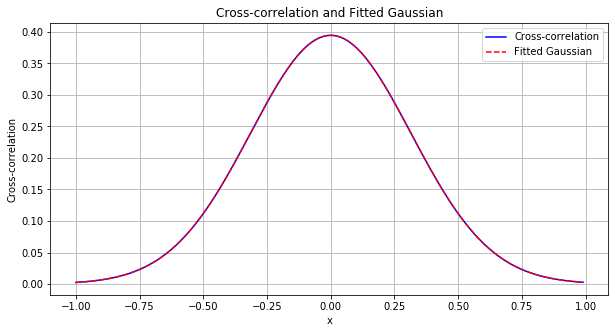

FWHM undiffused: 0.7412524426026665
Standard deviation of the fitted Gaussian: 0.31478092950959413


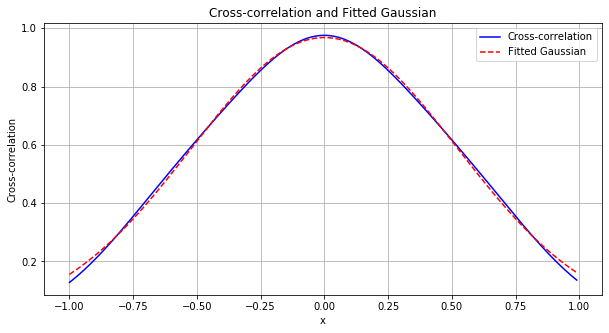

FWHM diffused: 1.2312638151212143
Standard deviation of the fitted Gaussian: 0.5228696000441222
% undiffused is 60.20256857217009
% undiffused is 60.20256857217009


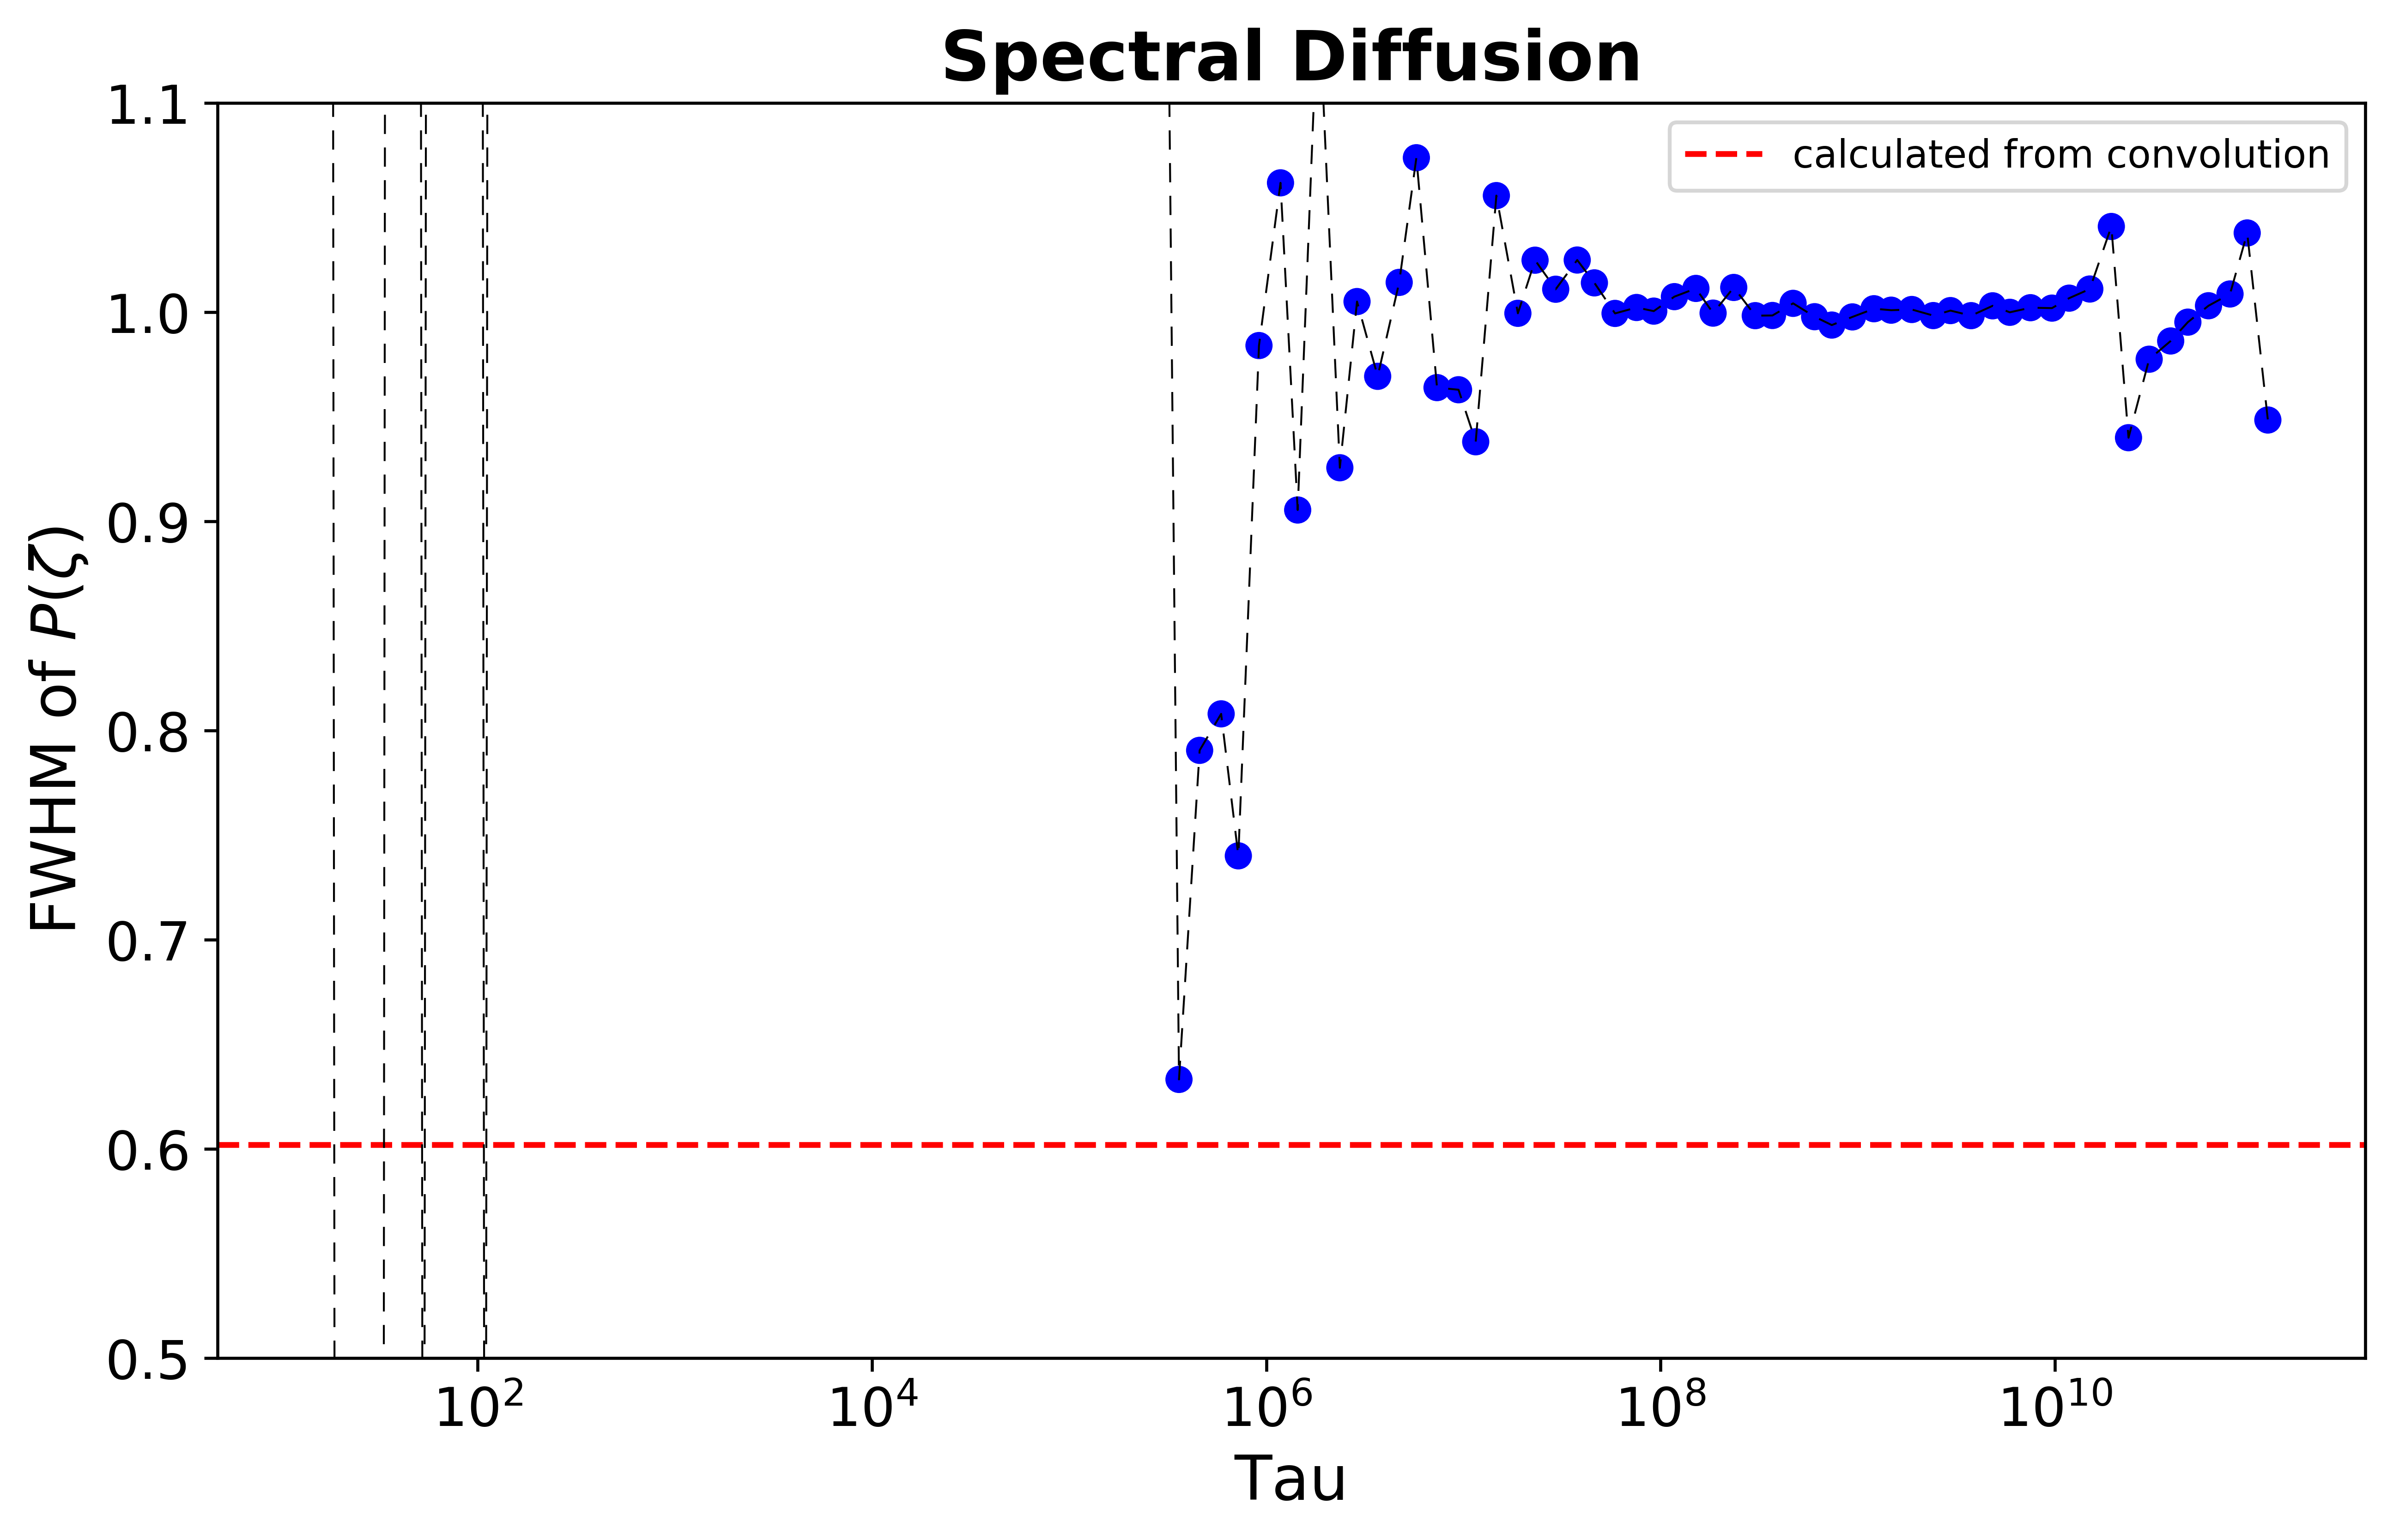

In [ ]:

'''
Check to see if the widths match the spectral convolution by calculating the correlation of the diffused spectra and the undiffused spectra
'''

'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian functions f(x) and g(x)
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Parameters for the Gaussian functions f(x) and g(x)
A_f = 1
mu_f = 0
sigma_f = std_dev

A_g = 1
mu_g = dif
sigma_g = std_dev

# Define the range and step size for x
x_min = -1
x_max = 1
delta_x = .01
x_values = np.arange(x_min, x_max, delta_x)

# Compute the values of f(x) and g(x)
f_x = gaussian(x_values, A_f, mu_f, sigma_f)
g_x = gaussian(x_values, A_g, mu_g, sigma_g)
g_x_neg = gaussian(x_values, A_g, -1*mu_g, sigma_g)
# Compute the cross-correlation
cross_corr_result = np.correlate(f_x, f_x, mode='same') * delta_x

# Fit the cross-correlation data to a Gaussian function
def fit_function(x, A, mu, sigma):
    return gaussian(x, A, mu, sigma)

popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Gaussian
A_fit, mu_fit, sigma_fit = popt

# Compute FWHM
FWHM1 = 2 * np.sqrt(2 * np.log(2)) * sigma_fit

# Compute standard deviation
std_deviation1 = sigma_fit

# Plot the original cross-correlation and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Gaussian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Gaussian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM undiffused:", FWHM1)
print("Standard deviation of the fitted Gaussian:", std_deviation1)


# Compute the cross-correlation
#you want to use 2fx+gx+gx_neg to get the time averaged spectra to work
cross_corr_result = np.correlate(f_x, 2*f_x+g_x+g_x_neg, mode='same') * delta_x

# Fit the cross-correlation data to a Gaussian function
def fit_function(x, A, mu, sigma):
    return gaussian(x, A, mu, sigma)

popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Gaussian
A_fit, mu_fit, sigma_fit = popt

# Compute FWHM
FWHM2 = 2 * np.sqrt(2 * np.log(2)) * sigma_fit

# Compute standard deviation
std_deviation2 = sigma_fit

# Plot the original cross-correlation and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Gaussian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Gaussian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM diffused:", FWHM2)
print("Standard deviation of the fitted Gaussian:", std_deviation2)

print('% undiffused is',(100*(FWHM1/FWHM2)))
print('% undiffused is',(100*(std_deviation1/std_deviation2)))

horizontal_line = np.abs(FWHM1/FWHM2)  # You can change this to your desired value
# Create a scatter plot with logarithmic scales and open circles
plt.figure(figsize=(10, 6), dpi=600)  # Adjust the figure size and DPI as needed
fwhm_arr_norm = fwhm_arr/fwhm_arr[85]

scatter = plt.scatter(pcfs1.tau, fwhm_arr_norm, c='blue', marker='o', edgecolors='none',)
plt.xscale('log')
#plt.xlim(1e4, 1e11)
plt.ylim(0.5, 1.1)

# Labeling and titles with larger font sizes
plt.xlabel('Tau', fontsize=16,  color='black')
plt.ylabel(rf'FWHM of $P(\zeta)$', fontsize=16, color='black')
plt.title('Spectral Diffusion', fontsize=18, fontweight='bold',color='black')

# Remove gridlines
plt.grid(False)

# Customize ticks and tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)


plt.axhline(y=horizontal_line, color='red', linestyle='--',label = 'calculated from convolution')

scatter.set_sizes([50])
custom_dash = [10, 7]
plt.plot(pcfs1.tau, fwhm_arr_norm, linestyle=(0, (custom_dash[0], custom_dash[1])), color='black', linewidth=0.5, )
#plt.savefig(r"C:\Data and Code\Data\23_10_06_4ATPsimulations\Plots\my_plot.png", dpi=300)

plt.legend()

plt.show()
'''


[0.7331128010450376, 1.5021534244370498, 0.26907569591922376, 0.027746197374987208, 0.004341402964611203, 0.008862315886107273, 0.06479096802154137, 0.031940268951565216, 0.009408046055063065, 0.1702163478196049]


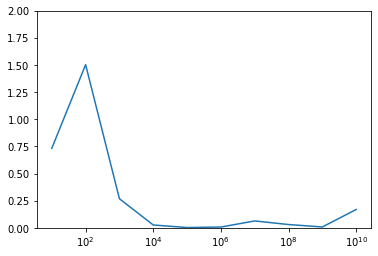

In [ ]:
'''
rmsd_arr = []
for k in range(10):
    log_bin = fwhm_arr_norm[(k*10):((k+1)*10)]
    mean_value = np.mean(log_bin)

    # Calculate the squared differences from the mean
    squared_diff = (log_bin - mean_value)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the RMSD by taking the square root of the mean squared difference
    rmsd = np.sqrt(mean_squared_diff)
    rmsd_arr.append(rmsd)
print(rmsd_arr)
plt.plot([10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],rmsd_arr)
plt.ylim(0,2)
plt.xscale('log')
plt.show()
#np.savetxt('/global/scratch/projects/co_utzatgroup/ccobbbruno/24_04_01_noise_approximations/photon_count'+f'{photon_number}',rmsd_arr)
'''

# Convolution for Lorenzian

0.03338767394632214 0.06678203136982575


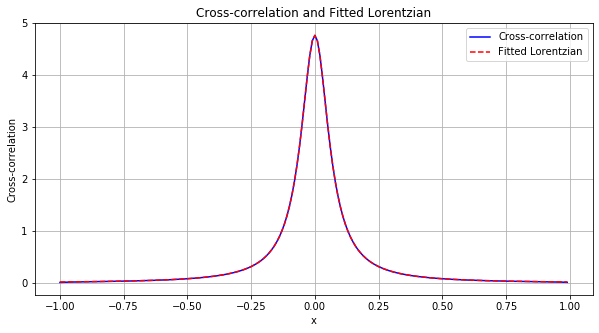

FWHM undiffused: 0.13352964045958304
Standard deviation of the fitted Lorentzian: 0.06676482022979152


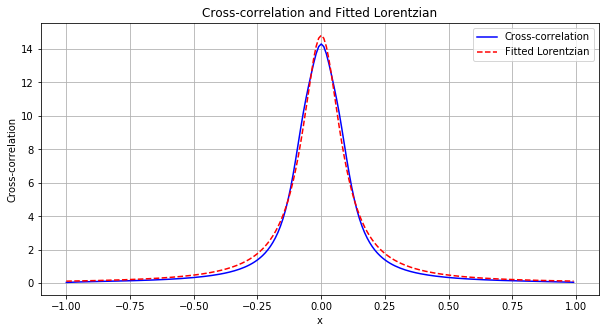

FWHM diffused: 0.1844459865058635
Standard deviation of the fitted Lorentzian: 0.09222299325293175
% undiffused is 72.39498293736966
% undiffused is 72.39498293736966


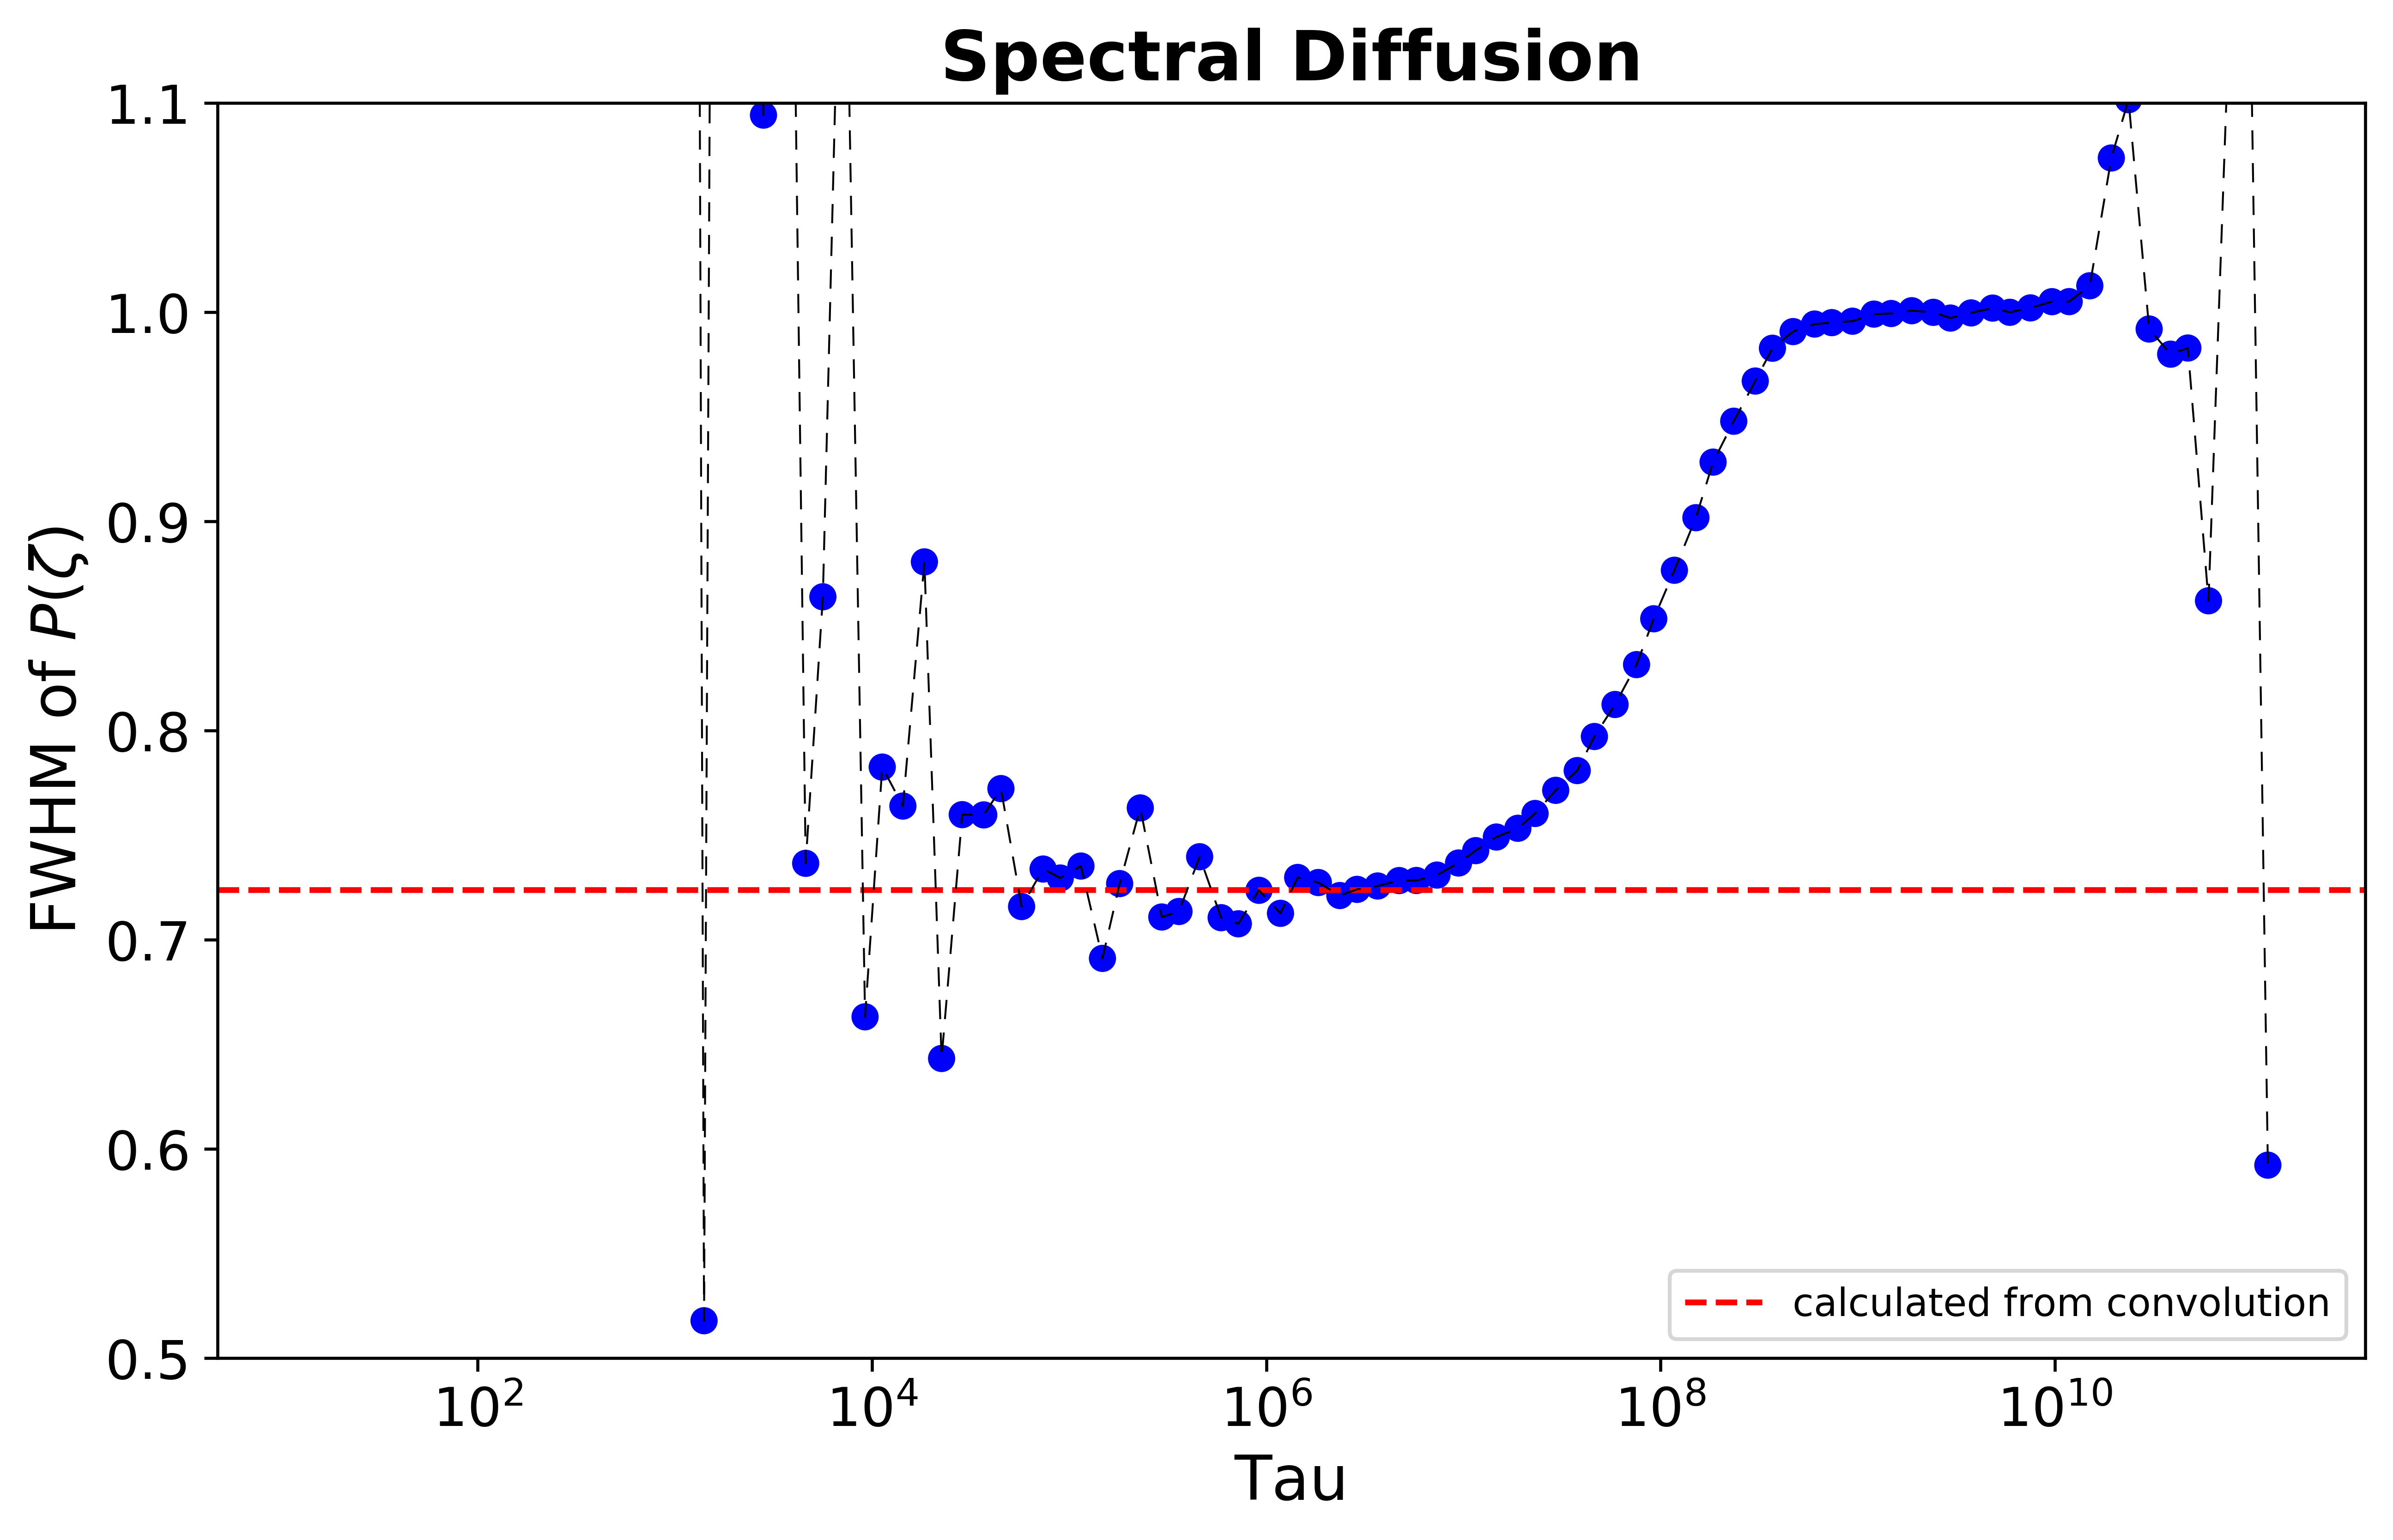